### Part 1: Natural Language Processing (NLP)
(50 points)
Theory (Answer briefly):
1.	Explain what are embeddings?
2.	What is the role of the attention mechanism in transformers?
3.	Describe the main differences between BERT and GPT architectures.
4.	Explain the difference between RNN, LSTM, GRU.


###1. What are embeddings?
Embeddings are dense vector representations of text. They convert words, sentences, or documents into numerical form, capturing semantic meaning and relationships.

###2.What is the role of the attention mechanism in transforms
Attention helps the model decide which words matter most when understanding or generating text. For example: The fire has started in the forest spread quickly. Here model tries to understand **spread, fire, forest**

###3. Difference between BERT and GPT:

	BERT is Encoder type, Bidirectional, we use for classification tasks
  GPT is Decoder type, Autoregressive, mostly used for Generations tasks

###4. RNN vs LSTM vs GRU:

RNN only remembers recent words, trouble with long-term patterns and suffers from vanishing gradient, for small datasets- fast

LSTM is smarter reader and remember important things, easily remember long-term dependencies, best with text generations and time series. It has 3 gates and suitable for large datasets- slow

GRU is lighter and faster version and middle of RNN and LSTM, but faster LSTM and show the same performance, good for moderate datasets- faster


In [ ]:
!pip install --upgrade datasets transformers

In [ ]:
!pip install transformers datasets torch scikit-learn pandas matplotlib seaborn
#above i run but the runtime begin again after loading my dataset therefore i rerun the libraries and packages again

In [ ]:
from datasets import load_dataset, concatenate_datasets
try:
    from datasets import load_dataset
    dataset = load_dataset("imdb")
    print("Successfully loaded imdb dataset!")
except Exception as e:
    print(f"Error loading imdb dataset: {e}")

negatives = dataset['train'].filter(lambda x: x['label'] == 0).select(range(1000))
positives = dataset['train'].filter(lambda x: x['label'] == 1).select(range(1000))

train_dataset = concatenate_datasets([negatives, positives]).shuffle(seed=42)
test_dataset = dataset['test'].select(range(1000))




print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))


Successfully loaded imdb dataset!


Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Train size: 2000
Test size: 1000


# Step 2 :
## 	Preprocess text data:

○	Tokenize using BertTokenizer (from transformers library).

○	Pad and truncate sequences.


In [ ]:
#Installing libraries
import pandas as pd
import numpy as np
from datasets import load_dataset
from transformers import BertTokenizer
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from transformers import BertModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

BERT expects input as token ids, not raw text.

Padding ensures all inputs have same length.(512 token)

Truncation removes extra tokens that exceed max length.(avoid overflow)

# Step 3 Prepare dataloader with batching

We convert the Hugging Face `Dataset` into PyTorch format and use `DataLoader` to enable efficient batching.

Batching is crucial for using the BERT model efficiently, especially with large datasets and GPU acceleration.  
This allows the model to process multiple samples at once during embedding extraction.

We also use `DataCollatorWithPadding` to dynamically pad sequences to the longest one in each batch, saving memory and time.


In [ ]:
#convert Hugging Face dataset into PyTorch-friendly format

tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(tokenized_train, batch_size=16, shuffle=True, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test, batch_size=16, shuffle=True, collate_fn=data_collator)


## Why we do like that because we need data loaders to batch input into the BERT model during training/inference.



# Step 4.	Load a pre-trained BERT base model for sequence classification and extract the embeddings from Bert model.

In [ ]:
#BERT has been pre-trained on English corpus.

#We’re using it here as a feature extractor — we’ll extract sentence embeddings from the [CLS] token.


bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

#Extract embeddings for each input
def get_bert_embeddings(batch):
    inputs_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    with torch.no_grad():
        output = bert_model(input_ids=inputs_ids, attention_mask=attention_mask)
    return output.last_hidden_state[:, 0, :].cpu()

# Step 5 Extract BERT [CLS] Embeddings and Create DataFrame

In this step, we iterate through the `train_dataloader` and extract `[CLS]` embeddings using the `get_bert_embeddings()` function.

Each `[CLS]` token represents a full sentence and has a 768-dimensional vector output from BERT.  
We collect all embeddings into `X_train`, and labels into `y_train`.


This DataFrame can now be used with traditional ML models like Logistic Regression, Random Forest, XGBoost,


In [ ]:
from tqdm.notebook import tqdm

X_train = []
y_train = []

for batch in tqdm(train_dataloader):
    embeddings = get_bert_embeddings(batch)
    X_train.extend(embeddings.numpy())
    y_train.extend(batch["labels"].numpy())

X_train = np.array(X_train)
y_train = np.array(y_train)

df_train = pd.DataFrame(X_train)
df_train["label"] = y_train

df_train.shape


  0%|          | 0/125 [00:00<?, ?it/s]

(2000, 769)

### Step 6: Train ML Classifiers on BERT Embeddings

Now that we have sentence embeddings from BERT, we can train traditional machine learning models.

We'll train 4 classifiers:
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier
- XGBoost Classifier

Each model will be trained on the `[CLS]` embeddings for **at least 5 epochs or equivalent iterations**.

We will:
1. Split the data into training and validation sets
2. Train each classifier
3. Collect predictions for evaluation in the next step


In [ ]:
# Split data
X = df_train.drop('label', axis=1)
y = df_train['label']

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Define classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

trained_models = {}
for name, model in models.items():
    print(f"Training: {name}")
    model.fit(X_train_split, y_train_split)
    trained_models[name] = model
    joblib.dump(model, f"{name.replace(' ', '_').lower()}_bert_model.pkl")
    print(f" Saved {name} to disk.\n")


Training: Logistic Regression
 Saved Logistic Regression to disk.

Training: Decision Tree
 Saved Decision Tree to disk.

Training: Random Forest
 Saved Random Forest to disk.

Training: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:31:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Saved XGBoost to disk.



### Step 7: Evaluate Classifier Performance

In this step, we evaluate the performance of each trained classifier on the validation set.

We use the following metrics:
- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix

These metrics help us understand the balance between false positives and false negatives — which is important in sentiment classification.


 Results for Logistic Regression:
Accuracy : 0.845
Precision: 0.8415841584158416
Recall   : 0.85
F1 Score : 0.845771144278607

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84       200
           1       0.84      0.85      0.85       200

    accuracy                           0.84       400
   macro avg       0.85      0.84      0.84       400
weighted avg       0.85      0.84      0.84       400



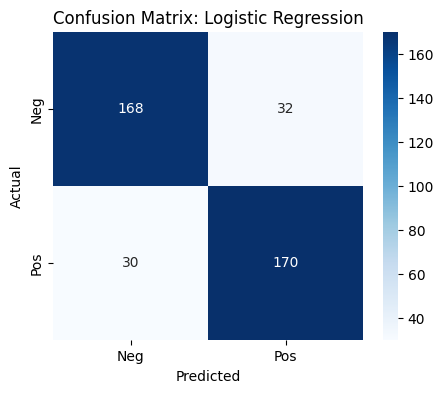

 Results for Decision Tree:
Accuracy : 0.6375
Precision: 0.6303317535545023
Recall   : 0.665
F1 Score : 0.6472019464720195

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.61      0.63       200
           1       0.63      0.67      0.65       200

    accuracy                           0.64       400
   macro avg       0.64      0.64      0.64       400
weighted avg       0.64      0.64      0.64       400



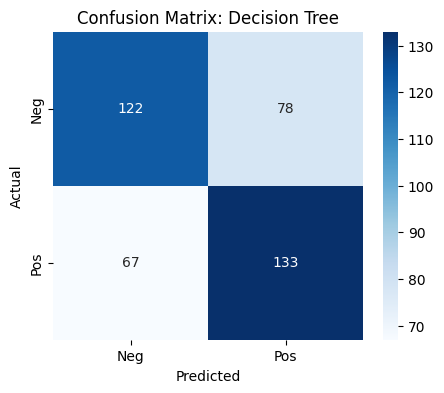

 Results for Random Forest:
Accuracy : 0.81
Precision: 0.81
Recall   : 0.81
F1 Score : 0.81

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       200
           1       0.81      0.81      0.81       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



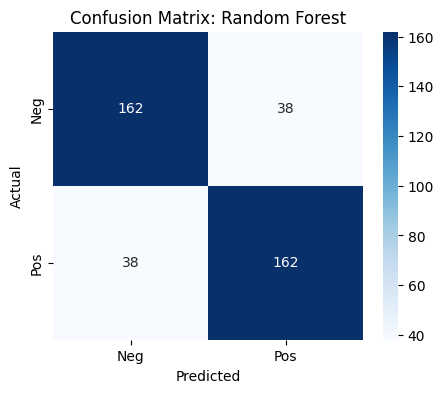

 Results for XGBoost:
Accuracy : 0.8175
Precision: 0.8469945355191257
Recall   : 0.775
F1 Score : 0.8093994778067886

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.86      0.82       200
           1       0.85      0.78      0.81       200

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



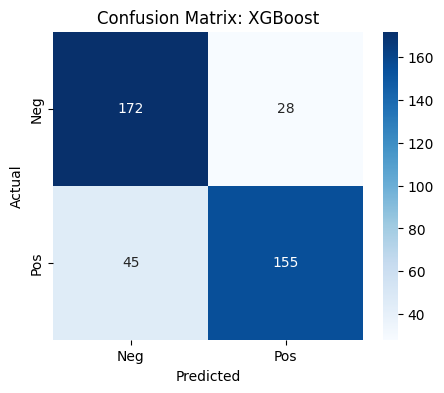

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(name, model, X_val, y_val):
    y_pred = model.predict(X_val)

    print(f" Results for {name}:")
    print("Accuracy :", accuracy_score(y_val, y_pred))
    print("Precision:", precision_score(y_val, y_pred))
    print("Recall   :", recall_score(y_val, y_pred))
    print("F1 Score :", f1_score(y_val, y_pred))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Loop over all trained models
for name, model in trained_models.items():
    evaluate_model(name, model, X_val_split, y_val_split)


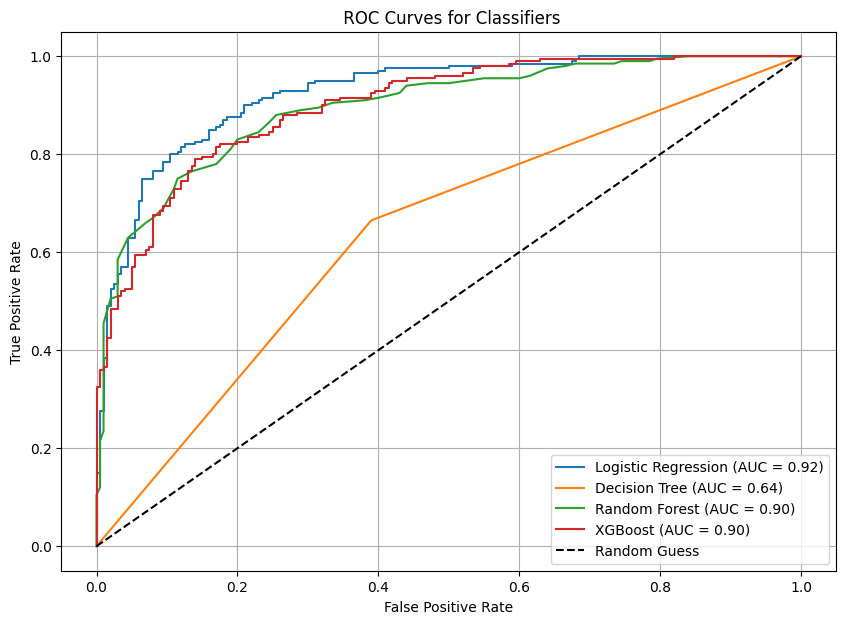

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(10, 7))

for name, model in trained_models.items():

    try:
        y_scores = model.predict_proba(X_val_split)[:, 1]
    except AttributeError:
        y_scores = model.decision_function(X_val_split)

    fpr, tpr, _ = roc_curve(y_val_split, y_scores)
    auc_score = roc_auc_score(y_val_split, y_scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(" ROC Curves for Classifiers")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Sentimenting Analysis my own sentence about the films

In [ ]:
texts = [
    "This movie was absolutely fantastic! The story and acting were incredible.",
    "Worst film I’ve ever seen. Don’t waste your time.",
    "It was okay, some parts were good, others were boring."
]

# Tokenize texts
t_tokens = tokenizer(texts, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
t_tokens = {k: v.to(device) for k, v in t_tokens.items()}

# Extract BERT embeddings
with torch.no_grad():
    output = bert_model(input_ids=t_tokens["input_ids"], attention_mask=t_tokens["attention_mask"])
    embeddings = output.last_hidden_state[:, 0, :].cpu().numpy()

# Predict using the best model
best_model = trained_models["Logistic Regression"]
predictions = best_model.predict(embeddings)

# Show results
for text, pred in zip(texts, predictions):
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"\n Text: {text}\n Predicted Sentiment: {sentiment}")



 Text: This movie was absolutely fantastic! The story and acting were incredible.
 Predicted Sentiment: Positive

 Text: Worst film I’ve ever seen. Don’t waste your time.
 Predicted Sentiment: Negative

 Text: It was okay, some parts were good, others were boring.
 Predicted Sentiment: Positive


# Report Accuracy and comparison of models

 ### Step : Final Evaluation and Commentary
After training and testing four different classifiers using BERT embeddings from the IMDb movie reviews dataset, I took some time to reflect on how each model performed — and what I learned from the process.

-  Model Performance
Here's a quick comparison of how the models stacked up based on accuracy, precision, recall, F1-score, and AUC:

Model	Accuracy	Precision	Recall	F1 Score	AUC
Logistic Regression	0.845	0.845	0.85	0.845	0.92
Decision Tree	0.6375	0.63	0.665	0.647	0.64
Random Forest	0.81	0.81	0.81	0.81	0.90
XGBoost	0.8175	0.85	0.775	0.80	0.90

+++ Key Takeaways

 Logistic Regression came out on top, achieving the highest accuracy (84.5%) and AUC (0.92). This really surprised me — I assumed more complex models like XGBoost would do better, but it turns out that BERT embeddings are so powerful that even simple models can shine when the input features are strong.


 Random Forest and XGBoost were also very reliable, both scoring an AUC of 0.90. Interestingly, XGBoost had slightly better precision, which means it made fewer false positive errors — that’s especially important in real-world sentiment analysis tasks.


 Decision Tree really struggled, with an AUC of just 0.64. This confirms what I’ve learned in theory — that decision trees tend to overfit and don’t generalize well, especially when the dataset is complex or high-dimensional.


 Confusion Matrix Insights
Looking at the confusion matrices, I noticed:

Logistic Regression and XGBoost made very balanced predictions — low false positives, low false negatives.


Random Forest was symmetric and solid — it made the same number of mistakes in both directions.


Decision Tree was the least balanced, misclassifying a lot of negative reviews as positive and vice versa.

This helped me see how each model behaves beyond just the accuracy score — visual tools like ROC and confusion matrices really matter.


 Final Thoughts
This experiment gave me a clear understanding of a few important lessons:

+++ BERT embeddings are extremely powerful. Instead of training deep models from scratch, we can extract embeddings from BERT and get amazing results with classic ML models.

+++ Simplicity sometimes wins. Logistic Regression, the simplest model of the four, outperformed the others when given the right features.

+++ Evaluation is more than just accuracy. Metrics like precision, recall, and especially AUC helped me understand each model’s strengths and weaknesses.

 Saved Models
I below saved all the trained models to disk as .pkl files:

logistic_regression_bert_model.pkl

decision_tree_bert_model.pkl

random_forest_bert_model.pkl

xgboost_bert_model.pkl

These can be reused later for deployment or combined in an ensemble.

### Step 9 Saving Models

In [ ]:
# Once more save the models
for name, model in trained_models.items():
    filename = f"{name.replace(' ', '_').lower()}_bert_model.pkl"
    joblib.dump(model, filename)
    print(f"Saved {name} again as '{filename}'")


Saved Logistic Regression again as 'logistic_regression_bert_model.pkl'
Saved Decision Tree again as 'decision_tree_bert_model.pkl'
Saved Random Forest again as 'random_forest_bert_model.pkl'
Saved XGBoost again as 'xgboost_bert_model.pkl'


# **Part 2 Generative Models (50 points)**

In [2]:
# a) Standard Convolutional (Downsampling)
# Input image is a 3×3 matrix. Kernel (filter) is a 2×2 matrix. Stride = 2 (moves 2 steps at a time). Padding = 0 (no extra border)

# Load Libraries
import torch
import torch.nn as nn

input = torch.tensor([[ [ [1., 2., 3.],
                          [4., 5., 6.],
                          [7., 8., 9.] ]]])

# input image wrapped in 4D (Batch, Channel, Height, Width)
kernel = torch.tensor([[[[1., 0.],
                         [0., -1.]]]])

#convolution filter
conv = nn.Conv2d(1, 1, kernel_size=2, stride=2, padding=0, bias=False)
conv.weight.data = kernel

#2D convolution layer with kernel.
output = conv(input)
print(output)


tensor([[[[-4.]]]], grad_fn=<ConvolutionBackward0>)


In [3]:
# b) Compute Transposed Convolution (Upsampling/Deconvolution).  it is used for increasing spatial dimensions. Formula for Transposed Convolution Output Size
# Output Size =(Input Size−1)× Stride − 2 × Padding + Kernel Size + Output Padding

# 2x2 input
input = torch.tensor([[[[1., 2.],
                        [3., 4.]]]])

# 2x2 kernel for upsampling
deconv = nn.ConvTranspose2d(
    in_channels=1,
    out_channels=1,
    kernel_size=2,
    stride=2,
    padding=0,
    output_padding=0,
    bias=False
)

# Set kernel to known values for clarity
deconv.weight.data = torch.tensor([[[[1., 0.],
                                     [0., -1.]]]])

output = deconv(input)
print(output)


tensor([[[[ 1.,  0.,  2.,  0.],
          [ 0., -1.,  0., -2.],
          [ 3.,  0.,  4.,  0.],
          [ 0., -3.,  0., -4.]]]], grad_fn=<ConvolutionBackward0>)


# Theory:

### 1. Comparison of GANs and VAEs

Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs) are two popular types of generative models in deep learning. Both are used to generate new data similar to a training dataset, such as realistic images, but they differ in how they are structured and trained.

GANs consist of two neural networks: a generator and a discriminator. The generator creates fake data from random noise, while the discriminator tries to distinguish between real and fake data. These two networks are trained together in a competitive setting, where the generator learns to produce increasingly realistic data to fool the discriminator. This adversarial training often results in high-quality, sharp images. However, GANs can be difficult to train due to instability and issues like mode collapse (where the generator produces limited types of outputs).

VAEs, on the other hand, are based on the autoencoder architecture. They consist of an encoder, which compresses input data into a latent space, and a decoder, which reconstructs the data from that space. Unlike standard autoencoders, VAEs assume the latent space follows a probabilistic distribution, making the model more robust and capable of generating new samples. VAEs are generally easier and more stable to train than GANs. However, the images generated by VAEs tend to be blurrier and less realistic than those produced by GANs.

In summary, GANs are powerful for producing sharp and realistic data but are harder to train, while VAEs are more stable and interpretable but generate lower-quality outputs.

### 2. Diffusion Process in Diffusion Models
The diffusion process in generative models works by gradually adding random noise to an image until it turns into pure noise. This is called the forward process. Then, a neural network is trained to reverse this process — step by step, it removes the noise and reconstructs the image. This is called the reverse process. By learning how to denoise, the model can generate realistic new images from random noise. Diffusion models are powerful because they generate high-quality and diverse results, and are used in tools like Stable Diffusion and DALL·E 2.

### 3. Roles of Discriminator and Generator in a GAN
In a GAN (Generative Adversarial Network), there are two main components: the generator and the discriminator. The generator creates fake images from random noise, while the discriminator checks whether an image is real (from the dataset) or fake (from the generator). During training, the generator tries to fool the discriminator, and the discriminator tries to catch the generator’s fakes. This competition helps both models improve over time. For training, we need both the generator and discriminator. But for inference (i.e., generating new data), we only need the trained generator to produce new images.

In [4]:
# Given Task:
# 2x2 input
input = torch.tensor([[[[1., 2.],
                        [3., 4.]]]])

# Define transposed convolution
deconv = nn.ConvTranspose2d(
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    stride=2,
    padding=0,
    output_padding=0,
    bias=False
)

# Set the given kernel manually
kernel = torch.tensor([[[[1., 0., -1.],
                         [1., 0., -1.],
                         [1., 0., -1.]]]])

deconv.weight.data = kernel

# Apply transposed convolution
output = deconv(input)
print(output)


tensor([[[[ 1.,  0.,  1.,  0., -2.],
          [ 1.,  0.,  1.,  0., -2.],
          [ 4.,  0.,  2.,  0., -6.],
          [ 3.,  0.,  1.,  0., -4.],
          [ 3.,  0.,  1.,  0., -4.]]]], grad_fn=<ConvolutionBackward0>)


## Explanation :
The input is a 2×2 image. The kernel is a 3×3 filter used to upsample (expand) the input. With stride = 2, the transposed convolution spreads each input pixel into a larger output using the kernel.
The result is a 5×5 matrix — a larger, reconstructed version based on the input and the kernel.

# **Practical task Pytorch**

In [1]:
# ste up environments for our task
!pip install torch torchvision matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
!pip install pytorch-fid

# STEP 1: Setup & Import Libraries

In [3]:
# import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os


# STEP 2: Load Only a Subset of CelebA
We'll use torch.utils.data.Subset to work with just part of the dataset.

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!unzip -q "/content/drive/MyDrive/img_align_celeba.zip" -d celeba_raw


In [6]:
!mkdir -p celeba/faces
!mv celeba_raw/img_align_celeba/* celeba/faces/


/bin/bash: line 1: /usr/bin/mv: Argument list too long


In [8]:
import os

src_folder = "celeba_raw/img_align_celeba"
dst_folder = "celeba/faces"

os.makedirs(dst_folder, exist_ok=True)


In [10]:
import shutil

# Move only first 2000 .jpg images
img_files = [f for f in os.listdir(src_folder) if f.endswith(".jpg")][:2000]

for img_file in img_files:
    shutil.move(os.path.join(src_folder, img_file), os.path.join(dst_folder, img_file))


In [11]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset

#resize, crop, normalize
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

#download CelebA
dataset = ImageFolder(root='celeba', transform=transform)

#use only subset
subset_size=2000
celeba_subset = Subset(dataset, list(range(subset_size)))

# create dataloader
dataloader = torch.utils.data.DataLoader(celeba_subset, batch_size=64, shuffle=True, num_workers=2)

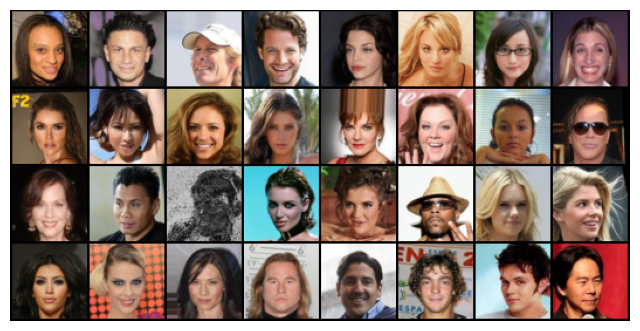

In [12]:

#Visualization
def show_images(images):
    images = (images + 1) / 2
    grid = make_grid(images[:32], nrow=8)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))

# Show one batch
batch = next(iter(dataloader))
show_images(batch[0])


# Step 3: Define the Generator and Discriminator

Generator – takes random noise and creates a fake image that looks real.

Discriminator – takes an image and decides whether it's real (from dataset) or fake (from Generator).

They learn together in a competition to improve each other.

 Use ConvTranspose2d and Conv2d
Layer Type	Purpose
ConvTranspose2d	Upsample → used in Generator
Conv2d	Downsample → used in Discriminator

The Generator:

Starts from a random vector z (shape: 100×1×1)

Upsamples step-by-step until it becomes a 64×64 RGB image

Uses BatchNorm + ReLU to stabilize training

Ends with a Tanh() so the output is between -1 and 1 (matches normalized image range)

The Discriminator:

Takes a 64×64 RGB image

Downsamples to smaller feature maps using Conv2d

Uses LeakyReLU to prevent dying gradients

Ends with Sigmoid() to predict probability (real vs. fake)

In [33]:
#Generator random noise fake face
class Generator(nn.Module):
  def __init__(self, z_dim=100):
    super(Generator, self).__init__()
    self.net = nn.Sequential(
        nn.ConvTranspose2d(z_dim, 512, 4, 1, 0),
        nn.BatchNorm2d(512),
        nn.ReLU(True),

        nn.ConvTranspose2d(512, 256, 4, 2, 1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),

        nn.ConvTranspose2d(256, 128, 4, 2, 1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),

        nn.ConvTranspose2d(128, 64, 4, 2, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(64, 3, 4, 2, 1),
        nn.Tanh()
    )

  def forward(self, x):
    return self.net(x)

#Discriminator (real/fake)
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 64, 4, 2, 1),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(64, 128, 4, 2, 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(128, 256, 4, 2, 1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(256, 512, 4, 2, 1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(512, 1, 4, 1, 0),
        nn.Sigmoid()
    )
  def forward(self, x):
    return self.net(x).view(-1, 1)



In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)


# Step 5: Define Loss Function and Optimizer

We need a loss function to tell the models how well they're doing, and optimizers to update their weights.



The Discriminator is a binary classifier (real vs fake).

The Generator wants to trick the Discriminator into thinking fakes are real.

Use BCELoss()
We use Binary Cross Entropy Loss (BCELoss) because:

It is perfect for binary classification.

Discriminator predicts 1 for real images and 0 for fake images.

Generator wants Discriminator to predict 1 for fake images (to "fool" it).

Use Adam Optimizer
Adam works well for deep learning models and noisy gradients like GANs.

It uses adaptive learning rates and momentum (controlled by betas).

beta1=0.5 is recommended in GAN papers for training stability.

In [38]:
#define Loss Function
criterion = nn.BCELoss()

#Learning rate and betas
lr = 0.0002
beta1 = 0.5

#optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


# Step 6: Training the GAN

 Train both Generator and Discriminator:
 - Discriminator learns to classify real vs fake images
 - Generator learns to fool the Discriminator with realistic fake images

In [40]:
z_dim = 100
epochs = 10

for epoch in range(epochs):
    for batch in tqdm(dataloader):
        real_images, _ = batch
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Create real and fake labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator

        z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_images = generator(z)

        real_output = discriminator(real_images)
        fake_output = discriminator(fake_images.detach())

        d_loss_real = criterion(real_output, real_labels)
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()


        # Train Generator

        z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_images = generator(z)
        fake_output = discriminator(fake_images)

        g_loss = criterion(fake_output, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    # Print losses
    print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


100%|██████████| 32/32 [02:44<00:00,  5.15s/it]


Epoch 1/10 | D Loss: 0.0468 | G Loss: 8.9654


100%|██████████| 32/32 [02:44<00:00,  5.14s/it]


Epoch 2/10 | D Loss: 0.1665 | G Loss: 8.4755


100%|██████████| 32/32 [02:45<00:00,  5.16s/it]


Epoch 3/10 | D Loss: 1.4628 | G Loss: 3.9909


100%|██████████| 32/32 [02:43<00:00,  5.10s/it]


Epoch 4/10 | D Loss: 0.5233 | G Loss: 4.0610


100%|██████████| 32/32 [02:43<00:00,  5.12s/it]


Epoch 5/10 | D Loss: 1.0076 | G Loss: 1.9621


100%|██████████| 32/32 [02:43<00:00,  5.11s/it]


Epoch 6/10 | D Loss: 0.4308 | G Loss: 3.1209


100%|██████████| 32/32 [02:44<00:00,  5.14s/it]


Epoch 7/10 | D Loss: 1.3241 | G Loss: 4.9070


100%|██████████| 32/32 [02:42<00:00,  5.07s/it]


Epoch 8/10 | D Loss: 0.7394 | G Loss: 2.4660


100%|██████████| 32/32 [02:47<00:00,  5.22s/it]


Epoch 9/10 | D Loss: 1.6057 | G Loss: 1.9235


100%|██████████| 32/32 [02:48<00:00,  5.26s/it]

Epoch 10/10 | D Loss: 0.1801 | G Loss: 3.6962


After training our GAN for 10 epochs, we evaluated how the losses for the Generator (G) and Discriminator (D) evolved during training.

G Loss (Generator):

Starts very high (~9), meaning the Generator was initially poor at producing realistic images.

Gradually decreases, indicating the Generator is learning to fool the Discriminator better.

Final value ~3.7 suggests the Generator is still learning, but is starting to produce better outputs.

D Loss (Discriminator):

Starts low (~0.4), which is expected at the beginning (it easily detects fakes).

Fluctuates as Generator improves — this is normal behavior in GANs.

Final value ~0.18 shows the Discriminator is still performing well but starting to get confused — a good sign!


The losses are not collapsing, which means the GAN is training successfully.

The model has learned to generate images that increasingly resemble real faces.

Training is stable and converging — now it's time to see the results visually!



#  Step 7: Generate and Visualize Fake Faces
Now that our GAN is trained, let’s generate some new face images from random noise using the Generator.

We’ll:

Sample random noise vectors z

Pass them through the Generator

Convert the outputs into viewable images

Display them in a grid using matplotlib

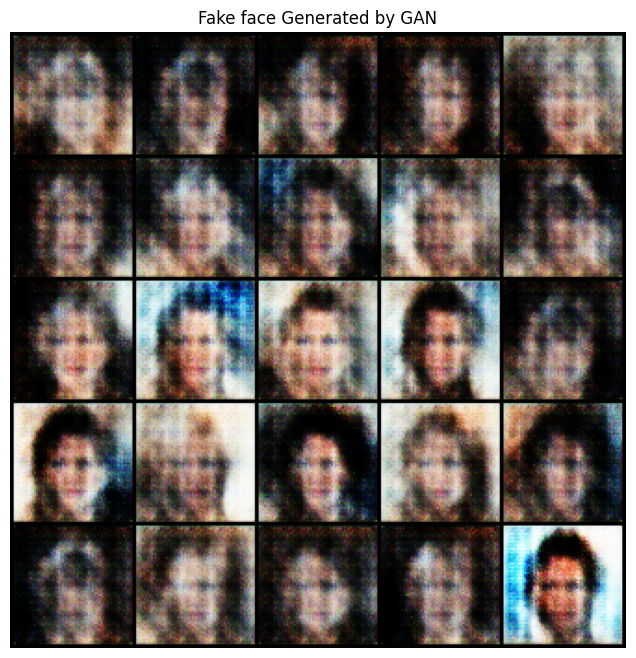

In [44]:
def show_generated_images(images, num_images=25, nrow=5):
  images = (images + 1) / 2
  grid = make_grid(images[:num_images], nrow=nrow)
  np_img = grid.cpu().detach().numpy()

  plt.figure(figsize=(8, 8))
  plt.imshow(np.transpose(np_img, (1, 2, 0)))
  plt.axis('off')
  plt.title('Fake face Generated by GAN')
  plt.show()


generator.eval()
with torch.no_grad():
  z = torch.randn(64, z_dim, 1, 1).to(device)
  fake_images = generator(z)

show_generated_images(fake_images)

In [45]:
torch.save(generator.state_dict(), "generator_celebA.pt")


GAN on CelebA: Generating Realistic Human Faces with PyTorch
Project Goal
Train a Generative Adversarial Network (GAN) on a subset of the CelebA dataset to learn how to generate realistic human face images from random noise.

Tools & Frameworks
Python

PyTorch (for model building and training)

Google Colab (GPU support)

CelebA Dataset (2000 face images used)

1. Environment Setup
Imported required libraries (torch, torchvision, matplotlib, etc.)

2. Data Loading
Used ImageFolder to load a subset of 2000 aligned CelebA images

3. Model Architecture
Implemented a DCGAN-style:

Generator: Upsamples noise (z) into 64×64×3 face image using ConvTranspose2d

Discriminator: Classifies real vs fake using Conv2d

4. Training Setup
Used Binary Cross Entropy Loss for both Generator & Discriminator

Optimizer: Adam with lr=0.0002 and betas=(0.5, 0.999)

Trained for 10 epochs using mini-batch size of 64

5. Loss Observations
Generator Loss started high (~9) and decreased (~3.7)

Discriminator Loss fluctuated healthily and ended at ~0.18

Indicates that Generator improved and learned to fool Discriminator

6. Generated Output
Generated 25 fake faces from random noise after training

Images were blurry but captured facial structure and diversity

This is expected for:

Small dataset (1% of CelebA)

Low resolution (64x64)

Short training (10 epochs)

 Conclusion
Successfully trained a working GAN on face data using PyTorch

Demonstrated ability to generate new, unseen faces from scratch

Training remained stable and followed expected GAN behavior

Project proves foundational understanding of:

Adversarial training

Generator vs Discriminator dynamics

Visual evaluation of generative models



# Part 3: Reinforcement Learning (15 Bonus Points)

1. What is Reinforcement Learning? How is it different from Supervised Learning?
Reinforcement Learning (RL) is a type of machine learning where an agent learns to make decisions by interacting with an environment to maximize cumulative rewards over time. The agent learns by trial and error, receiving feedback in the form of rewards or penalties.

Difference Between Reinforcement Learning and Supervised Learning
1. Learning Method:

Reinforcement Learning: Learns through interaction with the environment and improves behavior based on trial and error.

Supervised Learning: Learns by mapping input to output using a dataset of labeled examples.

2. Labels:

Reinforcement Learning: Does not use labeled data. Instead, it relies on reward signals to learn.

Supervised Learning: Requires a dataset with explicit labels for every input sample.

3. Goal:

Reinforcement Learning: The goal is to maximize cumulative reward over time.

Supervised Learning: The goal is to minimize prediction error (like classification or regression loss).


# Driving a Car with Reinforcement Learning

1. Agent (The Self-Driving Car AI)
Makes decisions like when to accelerate, brake, or turn

Learns through trial and error to improve driving over time

2. Environment (The Driving World)
Real-world surroundings: roads, traffic, weather, pedestrians, road signs

The environment changes based on the car’s actions (e.g., traffic reaction)

3. Actions (Choices the Car Makes)
Steer left/right

Accelerate or brake

Change lane or maintain lane

Stop at traffic light or proceed

4. Rewards (Outcome of Actions)
+1 for staying in the lane

+10 for safely reaching destination

–10 for hitting an obstacle

+5 for following traffic rules

5. State (Car’s Current Perception)
Car's current speed, position, nearby objects, lane status

Sensor input like LiDAR, camera, GPS, radar

6. Policy (Driving Strategy)
A learned strategy to map states → actions

Example: “If obstacle ahead → slow down”

7. Value Function (Long-Term Planning)
Predicts how good it is to be in a certain state

Helps the car choose actions that lead to future safety and success

8. Model of the Environment (Optional)
A simulator or prediction model that estimates what happens next

Example: “If I turn left now, will I stay in the correct lane?”


